In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import matplotlib.pyplot as plt
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"GPU Devices: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU Available: False


In [12]:
def load_processed_data(data_path='processed_data'):
    """Load preprocessed data from numpy archives"""
    print("Loading preprocessed data...")
    
    try:
        # Load training data
        train_data = np.load(os.path.join(data_path, 'train_images.npz'))
        train_images = train_data['images']
        train_labels = np.load(os.path.join(data_path, 'train_labels.npy'))
        
        # Load validation data
        val_data = np.load(os.path.join(data_path, 'val_images.npz'))
        val_images = val_data['images']
        val_labels = np.load(os.path.join(data_path, 'val_labels.npy'))
        
        # Load test data
        test_data = np.load(os.path.join(data_path, 'test_images.npz'))
        test_images = test_data['images']
        test_labels = np.load(os.path.join(data_path, 'test_labels.npy'))
        
        # Convert grayscale to RGB for transfer learning
        train_images_rgb = np.stack([train_images]*3, axis=-1)
        val_images_rgb = np.stack([val_images]*3, axis=-1)
        test_images_rgb = np.stack([test_images]*3, axis=-1)
        
        # Ensure float32 dtype
        train_images_rgb = train_images_rgb.astype('float32')
        val_images_rgb = val_images_rgb.astype('float32')
        test_images_rgb = test_images_rgb.astype('float32')
        
        print(f"✓ Training samples: {len(train_images)} - Shape: {train_images_rgb.shape}")
        print(f"✓ Validation samples: {len(val_images)} - Shape: {val_images_rgb.shape}")
        print(f"✓ Test samples: {len(test_images)} - Shape: {test_images_rgb.shape}")
        
        return {
            'train': (train_images_rgb, train_labels),
            'val': (val_images_rgb, val_labels),
            'test': (test_images_rgb, test_labels)
        }
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

In [13]:
# Cell 3: Execute Data Loading
# Load the data
data = load_processed_data('processed_data')

if data is not None:
    train_images, train_labels = data['train']
    val_images, val_labels = data['val']
    test_images, test_labels = data['test']
    
    # Calculate class weights for imbalanced dataset
    unique, counts = np.unique(train_labels, return_counts=True)
    total = len(train_labels)
    class_weights = {
        0: total / (2 * counts[0]),
        1: total / (2 * counts[1])
    }
    print(f"\nClass distribution in training:")
    print(f"  No Tumor (0): {counts[0]} samples ({counts[0]/total*100:.1f}%)")
    print(f"  Tumor (1): {counts[1]} samples ({counts[1]/total*100:.1f}%)")
    print(f"  Class weights: {class_weights}")
    
    # Verify data range
    print(f"\nData range check:")
    print(f"  Train min/max: {train_images.min():.3f} / {train_images.max():.3f}")
    print(f"  Val min/max: {val_images.min():.3f} / {val_images.max():.3f}")

Loading preprocessed data...
✓ Training samples: 245 - Shape: (245, 224, 224, 3)
✓ Validation samples: 38 - Shape: (38, 224, 224, 3)
✓ Test samples: 38 - Shape: (38, 224, 224, 3)

Class distribution in training:
  No Tumor (0): 136 samples (55.5%)
  Tumor (1): 109 samples (44.5%)
  Class weights: {0: np.float64(0.9007352941176471), 1: np.float64(1.1238532110091743)}

Data range check:
  Train min/max: 0.000 / 1.000
  Val min/max: 0.000 / 1.000


In [14]:
# Cell 4: Build Custom CNN Model (Alternative to EfficientNet)
def build_custom_cnn_model(input_shape=(224, 224, 3), num_classes=1):
    """Build a custom CNN model optimized for brain tumor detection"""
    
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Global pooling and dense layers
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    return model

In [15]:
# Cell 5: Alternative - Build EfficientNet-like Model using Keras Applications
def build_efficient_model_v2(input_shape=(224, 224, 3), num_classes=1):
    """Build model using MobileNetV2 as alternative to EfficientNet"""
    
    # Try using MobileNetV2 as a more stable alternative
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    
    # Freeze base model
    base_model.trainable = False
    
    # Build model
    inputs = layers.Input(shape=input_shape)
    
    # Preprocessing for MobileNetV2
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    
    # Base model
    x = base_model(x, training=False)
    
    # Custom head
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    
    model = models.Model(inputs, outputs)
    
    return model, base_model

In [17]:
print("Building Custom CNN Model...")
model = build_custom_cnn_model(input_shape=(224, 224, 3), num_classes=1)
base_model = None  # No base model for custom CNN

# Option 2: Try MobileNetV2 (uncomment to use)
# print("Building MobileNetV2-based Model...")
# model, base_model = build_efficient_model_v2(input_shape=(224, 224, 3), num_classes=1)

print(f"Model built successfully!")
print(f"Total parameters: {model.count_params():,}")

Building Custom CNN Model...
Model built successfully!
Total parameters: 1,442,337


In [18]:
# Cell 7: Compile Model
# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

print("Model compiled successfully!")

Model compiled successfully!


In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,442,337 (5.50 MB)

 Trainable params: 1,438,881 (5.49 MB)

 Non-trainable params: 3,456 (13.50 KB)

In [20]:
# Cell 9: Create Data Augmentation
def create_augmentation():
    """Create data augmentation layer"""
    return tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.15),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.2),
    ])

# Create augmentation layer
data_augmentation = create_augmentation()
print("Data augmentation layer created")

Data augmentation layer created


In [21]:
# Cell 10: Create TensorFlow Datasets
BATCH_SIZE = 16

# Create tf.data datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=len(train_labels))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

print(f"Datasets created with batch size: {BATCH_SIZE}")

Datasets created with batch size: 16


In [22]:
# Cell 11: Setup Callbacks
def create_callbacks(model_name="brain_tumor_model"):
    """Create training callbacks"""
    
    # Create directories
    os.makedirs('models', exist_ok=True)
    os.makedirs('logs', exist_ok=True)
    
    callbacks_list = [
        # Model checkpoint
        callbacks.ModelCheckpoint(
            filepath=f'models/{model_name}_best.h5',
            monitor='val_auc',
            mode='max',
            save_best_only=True,
            verbose=1
        ),
        
        # Early stopping
        callbacks.EarlyStopping(
            monitor='val_auc',
            patience=10,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
    ]
    
    return callbacks_list

# Create callbacks
training_callbacks = create_callbacks("brain_tumor_detector")
print("Callbacks created")

Callbacks created


In [23]:
# Cell 12: Train Model
print("="*50)
print("STARTING MODEL TRAINING")
print("="*50)

# Train the model
history = model.fit(
    train_dataset,
    epochs=30,  # Will stop early if no improvement
    validation_data=val_dataset,
    callbacks=training_callbacks,
    class_weight=class_weights,
    verbose=1
)

print("\nTraining completed!")

STARTING MODEL TRAINING
Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5809 - auc: 0.6073 - loss: 0.9182 - precision: 0.5393 - recall: 0.5943
Epoch 1: val_auc improved from None to 0.58116, saving model to models/brain_tumor_detector_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6327 - auc: 0.6796 - loss: 0.8578 - precision: 0.5785 - recall: 0.6422 - val_accuracy: 0.3947 - val_auc: 0.5812 - val_loss: 0.7609 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7452 - auc: 0.8000 - loss: 0.6037 - precision: 0.7171 - recall: 0.7821
Epoch 2: val_auc improved from 0.58116 to 0.78116, saving model to models/brain_tumor_detector_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.7020 - auc: 0.7598 - loss: 0.7136 - precision: 0.6475 - recall: 0.7248 - val_accuracy: 0.3947 - val_auc: 0.7812 - val_loss: 0.7486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7336 - auc: 0.8201 - loss: 0.5751 - precision: 0.6978 - recall: 0.7637
Epoch 3: val_auc did not improve from 0.78116
16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7061 - auc: 0.7843 - loss: 0.6754 - precision: 0.6480 - recall: 0.7431 - val_accuracy: 0.6053 - val_auc: 0.7522 - val_loss: 1.1323 - val_precision: 0.6053 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8142 - auc: 0.8678 - loss: 0.5000 - precision: 0.7683 - recall: 0.8485
Epoch 4: val_auc improved from 0.78116 to 0.80290, saving model to models/brain_tumor_detector_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.7388 - auc: 0.8034 - loss: 0.6244 - precision: 0.6860 - recall: 0.7615 - val_accuracy: 0.3947 - val_auc: 0.8029 - val_loss: 1.5947 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6174 - auc: 0.6661 - loss: 0.9641 - precision: 0.6129 - recall: 0.6653
Epoch 5: val_auc did not improve from 0.80290
16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.6531 - auc: 0.7248 - loss: 0.7917 - precision: 0.5923 - recall: 0.7064 - val_accuracy: 0.6053 - val_auc: 0.5000 - val_loss: 4.4486 - val_precision: 0.6053 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6261 - auc: 0.6981 - loss: 0.8180 - precision: 0.5541 - recall: 0.6821
Epoch 6: val_auc did not improve from 0.80290
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.6286 - auc: 0.6954 - loss: 0.7785 - precision: 0.5703 - recall: 0.6697 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7633 - auc: 0.8373 - loss: 0.5759 - precision: 0.7107 - recall: 0.7890 - val_accuracy: 0.6316 - val_auc: 0.8101 - val_loss: 1.2225 - val_precision: 0.6216 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 14/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7094 - auc: 0.8104 - loss: 0.6442 - precision: 0.6647 - recall: 0.6810
Epoch 14: val_auc did not improve from 0.81014
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7265 - auc: 0.8096 - loss: 0.6214 - precision: 0.6842 - recall: 0.7156 - val_accuracy: 0.7895 - val_auc: 0.7884 - val_loss: 0.6173 - val_precision: 0.8261 - val_recall: 0.8261 - learning_rate: 2.5000e-04
Epoch 15/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7610 - auc: 0.8128 - loss: 0.5666 - precision: 0.6829 - recall: 0.7948
Epoch 15: val_auc did not improve from 0.81014
16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.7551 - auc: 0.8026 - loss: 0.5872 - precision: 0.7059 - recall: 0.770

16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7061 - auc: 0.8075 - loss: 0.5851 - precision: 0.6667 - recall: 0.6789 - val_accuracy: 0.6316 - val_auc: 0.8130 - val_loss: 0.9658 - val_precision: 0.6216 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 18/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7546 - auc: 0.8210 - loss: 0.5504 - precision: 0.7114 - recall: 0.7840
Epoch 18: val_auc did not improve from 0.81304
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7551 - auc: 0.8459 - loss: 0.5084 - precision: 0.7025 - recall: 0.7798 - val_accuracy: 0.6842 - val_auc: 0.8087 - val_loss: 0.8348 - val_precision: 0.6571 - val_recall: 1.0000 - learning_rate: 2.5000e-04
Epoch 19/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6972 - auc: 0.8260 - loss: 0.5131 - precision: 0.6403 - recall: 0.6724
Epoch 19: val_auc did not improve from 0.81304

Epoch 19: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - acc

16/16 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8082 - auc: 0.8682 - loss: 0.4729 - precision: 0.7500 - recall: 0.8532 - val_accuracy: 0.6842 - val_auc: 0.8232 - val_loss: 0.7061 - val_precision: 0.6667 - val_recall: 0.9565 - learning_rate: 1.2500e-04
Epoch 23/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7612 - auc: 0.8287 - loss: 0.5330 - precision: 0.7119 - recall: 0.7861
Epoch 23: val_auc did not improve from 0.82319
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.7755 - auc: 0.8423 - loss: 0.5101 - precision: 0.7250 - recall: 0.7982 - val_accuracy: 0.7368 - val_auc: 0.8087 - val_loss: 0.6397 - val_precision: 0.7097 - val_recall: 0.9565 - learning_rate: 1.2500e-04
Epoch 24/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7307 - auc: 0.8324 - loss: 0.5294 - precision: 0.6614 - recall: 0.8086
Epoch 24: val_auc did not improve from 0.82319

Epoch 24: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accu

16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.7714 - auc: 0.8479 - loss: 0.5157 - precision: 0.7190 - recall: 0.7982 - val_accuracy: 0.7632 - val_auc: 0.8275 - val_loss: 0.5764 - val_precision: 0.7188 - val_recall: 1.0000 - learning_rate: 6.2500e-05
Epoch 29/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7838 - auc: 0.8702 - loss: 0.4949 - precision: 0.7469 - recall: 0.7913
Epoch 29: val_auc did not improve from 0.82754
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.7959 - auc: 0.8730 - loss: 0.4730 - precision: 0.7479 - recall: 0.8165 - val_accuracy: 0.7632 - val_auc: 0.8275 - val_loss: 0.5216 - val_precision: 0.7333 - val_recall: 0.9565 - learning_rate: 6.2500e-05
Epoch 30/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7817 - auc: 0.8874 - loss: 0.4304 - precision: 0.7421 - recall: 0.7907
Epoch 30: val_auc did not improve from 0.82754
16/16 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.7714 - auc: 0.8588 - loss: 0.4904 - precision: 0.7190 - recall: 0.798

In [24]:
# Cell 13: Setup Fine-Tuning Phase
print("\n" + "="*60)
print("PHASE 2: FINE-TUNING FOR IMPROVED ACCURACY")
print("="*60)

from tensorflow.keras.models import load_model
import numpy as np

# Load your best model from previous training
print("Loading best model from initial training...")
model = load_model('models/brain_tumor_detector_best.h5')

print(f"✓ Model loaded successfully")
print(f"  Previous best validation AUC: 0.8275")
print(f"  Previous validation accuracy: 76.32%")
print(f"  Target: >85% accuracy\n")


PHASE 2: FINE-TUNING FOR IMPROVED ACCURACY
Loading best model from initial training...


✓ Model loaded successfully
  Previous best validation AUC: 0.8275
  Previous validation accuracy: 76.32%
  Target: >85% accuracy



In [30]:
# Cell 14: FIXED Learning Rate Scheduler
class CyclicalLearningRate(tf.keras.callbacks.Callback):
    """Fixed Cyclical Learning Rate compatible with newer TensorFlow"""
    def __init__(self, base_lr=1e-6, max_lr=1e-4, step_size=100):
        super().__init__()
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.iteration = 0
        
    def on_batch_begin(self, batch, logs=None):
        cycle = np.floor(1 + self.iteration / (2 * self.step_size))
        x = np.abs(self.iteration / self.step_size - 2 * cycle + 1)
        lr = self.base_lr + (self.max_lr - self.base_lr) * np.maximum(0, (1 - x))
        
        # Fixed: Use the correct method to set learning rate
        self.model.optimizer.learning_rate.assign(lr)
        self.iteration += 1

print("✓ Fixed Cyclical Learning Rate scheduler created")
print("  Base LR: 1e-6")
print("  Max LR: 1e-4")
print("  This will help escape local minima\n")

✓ Fixed Cyclical Learning Rate scheduler created
  Base LR: 1e-6
  Max LR: 1e-4
  This will help escape local minima



In [31]:
# Cell 15: Recompile Model with Lower Learning Rate
# Use much lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # 100x lower than initial
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

print("Model recompiled for fine-tuning:")
print("  Initial learning rate: 1e-5 (very low)")
print("  Will cycle between 1e-6 and 1e-4")

Model recompiled for fine-tuning:
  Initial learning rate: 1e-5 (very low)
  Will cycle between 1e-6 and 1e-4


In [32]:
# Cell 16: Create Fine-Tuning Callbacks
from datetime import datetime

# Create callbacks for fine-tuning phase
finetune_callbacks = [
    # Save best model with new name
    tf.keras.callbacks.ModelCheckpoint(
        'models/brain_tumor_finetuned_best.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    
    # Early stopping with more patience
    tf.keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=15,  # More patience for fine-tuning
        mode='max',
        restore_best_weights=True,
        verbose=1,
        min_delta=0.001  # Only stop if improvement < 0.1%
    ),
    
    # Cyclical learning rate
    CyclicalLearningRate(base_lr=1e-6, max_lr=1e-4, step_size=100),
    
    # Reduce on plateau as backup
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.8,
        patience=5,
        min_lr=1e-8,
        verbose=1
    ),
    
    # TensorBoard for monitoring
    tf.keras.callbacks.TensorBoard(
        log_dir=f'logs/finetune_{datetime.now().strftime("%Y%m%d_%H%M%S")}',
        histogram_freq=0
    )
]

print("Callbacks ready for fine-tuning")


Callbacks ready for fine-tuning


In [33]:
# Cell 17: Execute Fine-Tuning
print("\n" + "="*60)
print("STARTING FINE-TUNING...")
print("="*60)
print("\nTraining settings:")
print("  • Starting from epoch 29 (continuing from previous best)")
print("  • Maximum 30 additional epochs")
print("  • Using cyclical learning rate")
print("  • Maintaining class weights")
print("  • Early stopping if no improvement for 15 epochs\n")

# Fine-tune the model
history_finetune = model.fit(
    train_dataset,
    epochs=30,  # Will train for up to 30 more epochs
    validation_data=val_dataset,
    callbacks=finetune_callbacks,
    class_weight=class_weights,
    verbose=1,
    initial_epoch=0  # Start fresh epoch counting for clarity
)

print("\n✓ Fine-tuning complete!")


STARTING FINE-TUNING...

Training settings:
  • Starting from epoch 29 (continuing from previous best)
  • Maximum 30 additional epochs
  • Using cyclical learning rate
  • Maintaining class weights
  • Early stopping if no improvement for 15 epochs

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8338 - auc: 0.8870 - loss: 0.4624 - precision: 0.7586 - recall: 0.8980
Epoch 1: val_auc improved from None to 0.82899, saving model to models/brain_tumor_finetuned_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.8122 - auc: 0.8753 - loss: 0.4660 - precision: 0.7603 - recall: 0.8440 - val_accuracy: 0.7368 - val_auc: 0.8290 - val_loss: 0.5717 - val_precision: 0.7097 - val_recall: 0.9565 - learning_rate: 1.5850e-05
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7999 - auc: 0.8789 - loss: 0.4569 - precision: 0.7705 - recall: 0.7958
Epoch 2: val_auc improved from 0.82899 to 0.83478, saving model to models/brain_tumor_finetuned_best.h5


16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.7755 - auc: 0.8532 - loss: 0.4974 - precision: 0.7368 - recall: 0.7706 - val_accuracy: 0.7105 - val_auc: 0.8348 - val_loss: 0.6262 - val_precision: 0.6875 - val_recall: 0.9565 - learning_rate: 3.1690e-05
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7916 - auc: 0.8838 - loss: 0.4287 - precision: 0.7518 - recall: 0.8107
Epoch 3: val_auc did not improve from 0.83478
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 5s/step - accuracy: 0.7959 - auc: 0.8790 - loss: 0.4367 - precision: 0.7479 - recall: 0.8165 - val_accuracy: 0.6842 - val_auc: 0.8145 - val_loss: 0.5725 - val_precision: 0.6774 - val_recall: 0.9130 - learning_rate: 4.7530e-05
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7562 - auc: 0.8591 - loss: 0.4885 - precision: 0.6727 - recall: 0.7899
Epoch 4: val_auc did not improve from 0.83478
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7551 - auc: 0.8350 - loss: 0.5347 - precision: 0.7025 - recall: 0.7798 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.7959 - auc: 0.8807 - loss: 0.4418 - precision: 0.7438 - recall: 0.8257 - val_accuracy: 0.6842 - val_auc: 0.8420 - val_loss: 0.5172 - val_precision: 0.6897 - val_recall: 0.8696 - learning_rate: 7.9210e-05
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7649 - auc: 0.8659 - loss: 0.4847 - precision: 0.7565 - recall: 0.7638
Epoch 6: val_auc did not improve from 0.84203
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 3s/step - accuracy: 0.7796 - auc: 0.8733 - loss: 0.4824 - precision: 0.7273 - recall: 0.8073 - val_accuracy: 0.6842 - val_auc: 0.8319 - val_loss: 0.6336 - val_precision: 0.6774 - val_recall: 0.9130 - learning_rate: 9.5050e-05
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7785 - auc: 0.8497 - loss: 0.5170 - precision: 0.7436 - recall: 0.8005
Epoch 7: val_auc did not improve from 0.84203
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8000 - auc: 0.8716 - loss: 0.4653 - precision: 0.7500 - recall: 0.8257 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - accuracy: 0.8163 - auc: 0.8871 - loss: 0.4392 - precision: 0.7807 - recall: 0.8165 - val_accuracy: 0.7895 - val_auc: 0.8681 - val_loss: 0.4861 - val_precision: 0.8000 - val_recall: 0.8696 - learning_rate: 7.3270e-05
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7903 - auc: 0.8757 - loss: 0.4717 - precision: 0.7207 - recall: 0.7897
Epoch 9: val_auc did not improve from 0.86812
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.8163 - auc: 0.8918 - loss: 0.4309 - precision: 0.7759 - recall: 0.8257 - val_accuracy: 0.7368 - val_auc: 0.8638 - val_loss: 0.4927 - val_precision: 0.7407 - val_recall: 0.8696 - learning_rate: 5.7430e-05
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8343 - auc: 0.8991 - loss: 0.4269 - precision: 0.7696 - recall: 0.8588
Epoch 10: val_auc did not improve from 0.86812
16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8122 - auc: 0.8798 - loss: 0.4621 - precision: 0.7739 - recall: 0.8165 


📊 FINE-TUNING RESULTS:
Best Epoch: 8
Best Validation Accuracy: 0.7895 (78.95%)
Best Validation AUC: 0.8681

Improvement over previous best:
  Accuracy: +2.63%
  AUC: +4.0616


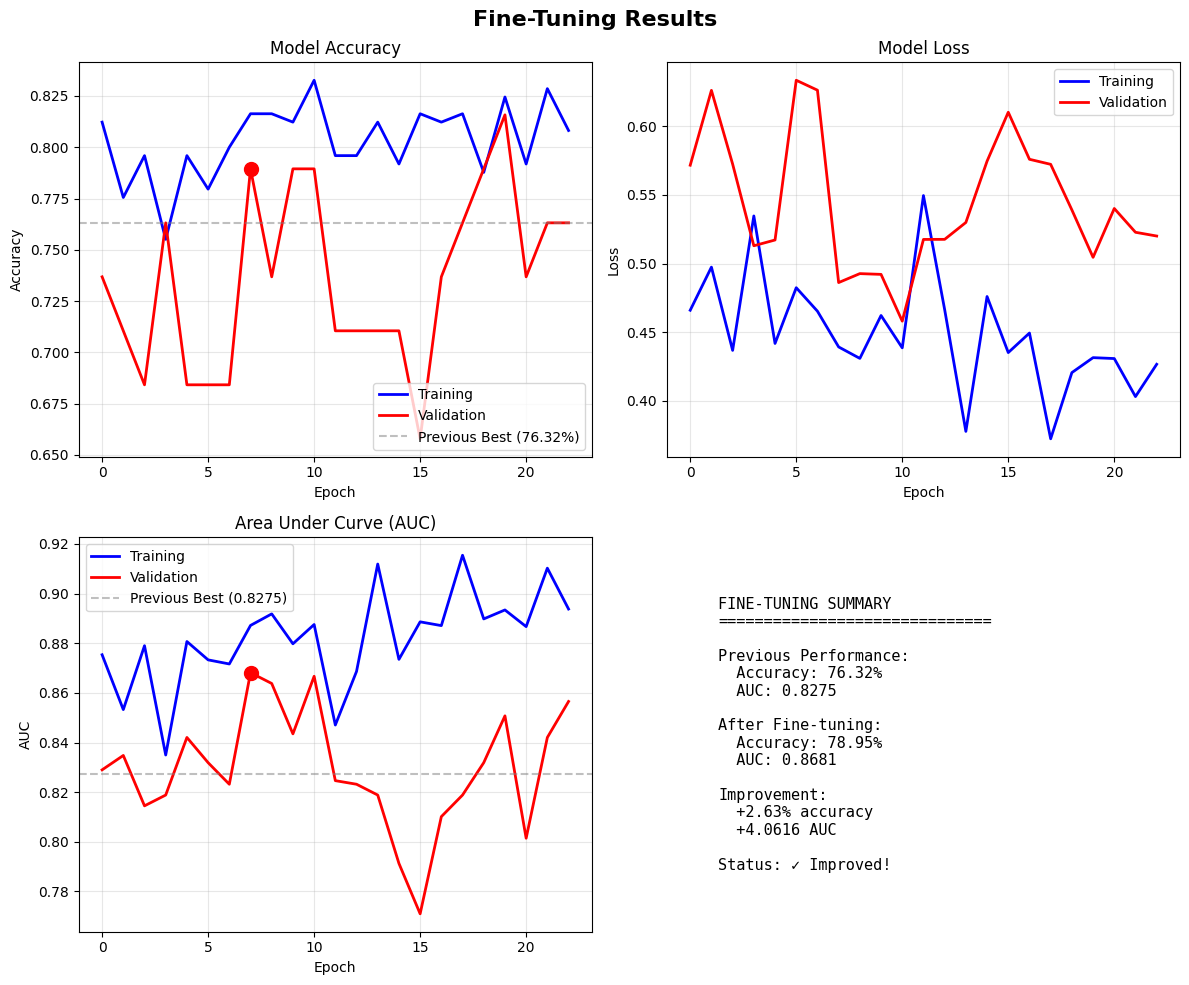

In [34]:
# Cell 18: Analyze Fine-Tuning Results
import matplotlib.pyplot as plt

# Get the history
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
auc = history_finetune.history['auc']
val_auc = history_finetune.history['val_auc']

# Find best epoch
best_epoch = np.argmax(val_auc)
best_val_acc = val_acc[best_epoch]
best_val_auc = val_auc[best_epoch]

print(f"\n📊 FINE-TUNING RESULTS:")
print("="*60)
print(f"Best Epoch: {best_epoch + 1}")
print(f"Best Validation Accuracy: {best_val_acc:.4f} ({best_val_acc*100:.2f}%)")
print(f"Best Validation AUC: {best_val_auc:.4f}")

# Calculate improvement
improvement_acc = (best_val_acc - 0.7632) * 100
improvement_auc = (best_val_auc - 0.8275) * 100

print(f"\nImprovement over previous best:")
print(f"  Accuracy: {'+' if improvement_acc > 0 else ''}{improvement_acc:.2f}%")
print(f"  AUC: {'+' if improvement_auc > 0 else ''}{improvement_auc:.4f}")

# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Fine-Tuning Results', fontsize=16, fontweight='bold')

# Accuracy plot
axes[0, 0].plot(acc, 'b-', label='Training', linewidth=2)
axes[0, 0].plot(val_acc, 'r-', label='Validation', linewidth=2)
axes[0, 0].axhline(y=0.7632, color='gray', linestyle='--', alpha=0.5, label='Previous Best (76.32%)')
axes[0, 0].scatter(best_epoch, best_val_acc, color='red', s=100, zorder=5)
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss plot
axes[0, 1].plot(loss, 'b-', label='Training', linewidth=2)
axes[0, 1].plot(val_loss, 'r-', label='Validation', linewidth=2)
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC plot
axes[1, 0].plot(auc, 'b-', label='Training', linewidth=2)
axes[1, 0].plot(val_auc, 'r-', label='Validation', linewidth=2)
axes[1, 0].axhline(y=0.8275, color='gray', linestyle='--', alpha=0.5, label='Previous Best (0.8275)')
axes[1, 0].scatter(best_epoch, best_val_auc, color='red', s=100, zorder=5)
axes[1, 0].set_title('Area Under Curve (AUC)')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Summary text
axes[1, 1].axis('off')
summary_text = f"""
FINE-TUNING SUMMARY
{'='*30}

Previous Performance:
  Accuracy: 76.32%
  AUC: 0.8275

After Fine-tuning:
  Accuracy: {best_val_acc*100:.2f}%
  AUC: {best_val_auc:.4f}
  
Improvement:
  {'+' if improvement_acc > 0 else ''}{improvement_acc:.2f}% accuracy
  {'+' if improvement_auc > 0 else ''}{improvement_auc:.4f} AUC
  
Status: {'✓ Improved!' if improvement_acc > 0 else '⚠ No improvement'}
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11, 
                family='monospace', verticalalignment='center')

plt.tight_layout()
plt.show()